In [154]:
import matplotlib.pyplot as plt
import seaborn as sns
from torchsummary import summary
from collections import Counter

from data import load_data
from model import Model
from main import test

### Load data

The dataset treated in this notebook is the German Traffic Sign Recognition Benchmmark. It presents a multi-class classification problem with 43 classes and more than 50000 images. Some illustrations regarding the data will be given below.

J. Stallkamp, M. Schlipsing, J. Salmen, C. Igel, Man vs. computer: Benchmarking machine learning algorithms for traffic sign recognition, Neural Networks, Available online 20 February 2012, ISSN 0893-6080, 10.1016/j.neunet.2012.02.016. (http://www.sciencedirect.com/science/article/pii/S0893608012000457) Keywords: Traffic sign recognition; Machine learning; Convolutional neural networks; Benchmarking

In [155]:
train_loader, val_loader, test_loader = load_data(batch_size=512)
y = [y for (x, y) in train_loader.dataset]
y_count = Counter(y)
y_count = {str(k): v for k, v in sorted(y_count.items(), key=lambda item: item[1], reverse=True)}

### Class imbalance

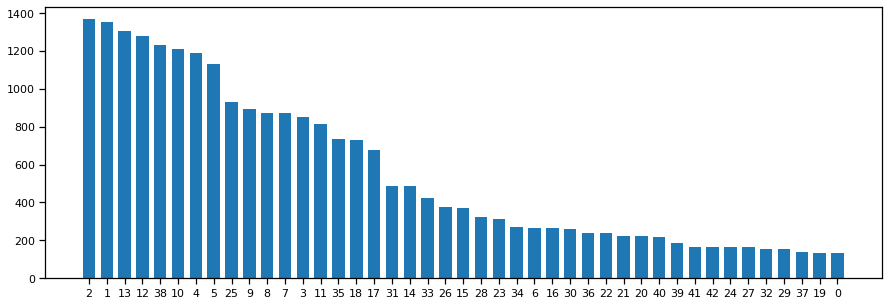

In [62]:
plt.figure(figsize=(15, 5))
plt.bar(x=list(y_count.keys()), height=list(y_count.values()), width=0.7)
plt.show()

What do the 5 most frequent and infrequent traffic signs look like?

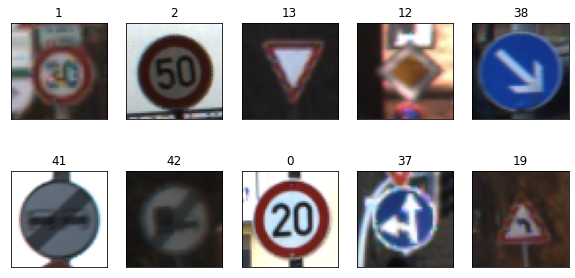

In [146]:
most_frequent = list(y_count.keys())[:5]
least_frequent = list(y_count.keys())[-5:]

idx, (x, y) = next(enumerate(train_loader))

plt.figure(figsize=(10, 5))
for idx, i in enumerate(most_frequent):
    plt.subplot(2, 5, idx+1)
    traffic_sign = x[y == int(i)][0]
    plt.imshow(traffic_sign.permute(1, 2, 0))
    plt.title(i)
    plt.xticks([])
    plt.yticks([])
for idx, i in enumerate(least_frequent):
    plt.subplot(2, 5, idx+6)
    traffic_sign = x[y == int(i)][0]
    plt.imshow(traffic_sign.permute(1, 2, 0))
    plt.title(i)
    plt.xticks([])
    plt.yticks([])
plt.show()

### The model

The architecture of the model has been inspired by Arcos-Garcia et al. (2018, https://doi.org/10.1016/j.neunet.2018.01.005). 

In [169]:
model = Model().cuda()
summary(model, (3, 50, 50))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 200, 44, 44]          29,600
              ReLU-2          [-1, 200, 44, 44]               0
         MaxPool2d-3          [-1, 200, 22, 22]               0
       BatchNorm2d-4          [-1, 200, 22, 22]             400
            Conv2d-5          [-1, 200, 19, 19]         640,200
              ReLU-6          [-1, 200, 19, 19]               0
         MaxPool2d-7            [-1, 200, 9, 9]               0
       BatchNorm2d-8            [-1, 200, 9, 9]             400
            Conv2d-9            [-1, 350, 6, 6]       1,120,350
             ReLU-10            [-1, 350, 6, 6]               0
      BatchNorm2d-11            [-1, 350, 6, 6]             700
          Flatten-12                [-1, 12600]               0
           Linear-13                 [-1, 1024]      12,903,424
          Dropout-14                 [-

### Training the model

In [1]:
!python3 main.py

Number of params: 15245005
Epoch  | Loss    | Validation loss | Validation accuracy
0      | 3.7599  | 3.7612          | 0.0215
0      | 3.6139  | 3.7442          | 0.0547
0      | 3.4009  | 3.6555          | 0.1465
0      | 3.2898  | 3.4693          | 0.3555
0      | 3.1498  | 3.2717          | 0.5654
0      | 3.0733  | 3.1792          | 0.6650
0      | 3.0088  | 3.0475          | 0.7773
0      | 2.9641  | 3.0154          | 0.8086
0      | 2.9436  | 2.9488          | 0.8799
0      | 2.8726  | 2.9074          | 0.9102
1      | 2.8918  | 2.9130          | 0.8994
1      | 2.8730  | 2.8964          | 0.9209
1      | 2.8453  | 2.8795          | 0.9326
1      | 2.8353  | 2.8780          | 0.9307
1      | 2.8391  | 2.8585          | 0.9609
1      | 2.8326  | 2.8443          | 0.9668
1      | 2.8237  | 2.8386          | 0.9717
1      | 2.8251  | 2.8262          | 0.9824
1      | 2.8323  | 2.8361          | 0.9736
1      | 2.8231  | 2.8307          | 0.9766
2      | 2.8170  | 2.8278          |

### Inspecting missclassifications

In [2]:
with open("output/classification_report.txt", "r") as file:
    classification_report = file.read()

print(classification_report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        64
           1       0.98      0.99      0.98       751
           2       0.98      0.99      0.99       793
           3       0.99      0.97      0.98       444
           4       0.98      0.97      0.97       684
           5       0.93      0.97      0.95       651
           6       1.00      0.84      0.91       141
           7       0.98      0.95      0.97       479
           8       0.94      0.98      0.96       479
           9       0.99      1.00      0.99       477
          10       1.00      0.99      0.99       721
          11       0.95      0.92      0.93       486
          12       1.00      1.00      1.00       757
          13       0.99      1.00      0.99       730
          14       1.00      0.99      1.00       302
          15       0.95      1.00      0.98       230
          16       0.99      1.00      0.99       169
          17       0.99    

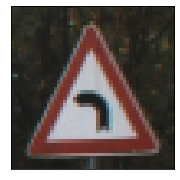

In [165]:
def plot_test_examples(target: int):
    idx, (x_test, y_test) = next(enumerate(test_loader))
    sample = x_test[y_test == target]
    n_samples = sample.shape[0]

    if n_samples == 0:
        return "No examples found in test batch."
    
    plt.figure(figsize=(3*n_samples, 3))
    for i in range(n_samples):
        plt.subplot(1, n_samples, i+1)
        plt.imshow(sample[i].permute(1, 2, 0))
        plt.xticks([])
        plt.yticks([])


plot_test_examples(target=27)